# Domain Adaptation in Computer Vision

This notebook aims to prove if Domain Adaptation, specifically CORAL Loss, is effective at improving CNN accuracy.

Original Paper found [here](https://arxiv.org/pdf/1607.01719)

 This project uses the Office-31 dataset, shortened down from 35 classes to 7 classes to reduce operations

## Office-31 Dataset:
 This dataset is comprised of 35 classes of objects and images taken through 3 different cameras: Webcam, DSLR, Amazon. These cameras vary in focus, haze, saturation, creating randomized errors that reflect real world Convolutional Neural Networks (CNN) applications.

 This project uses DSLR for training and Webcam for validation, testing the ability of the EfficientNet V2 model to detect generalized, domain-invariant features which exist among all samples, through being exposed to an object, seen through the lens of a faulty camera, to a better quality camera.

 This investigation uses the first 10 classes of Office-31 for simplicity

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install torch efficientnet_pytorch
%pip install --quiet torch torchvision efficientnet_pytorch scipy
%pip install --upgrade torchvision

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16477 sha256=815c0092d3459e5da557aaa6ea53a5fb12794b7ee64ec87328ed8df9a8d9bbb6
  Stored in directory: /Users/adityachakraborty/Library/Caches/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 59.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstal

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
import random
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt


In [6]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
TRIALS = 3
NUM_CLASSES = 10

# Load datasets
root_dir = 'Office-31/'

In [7]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Transform to match EfficientNet input size
    transforms.ToTensor(), #Convert to tensor for PyTorch computation
])

# Load datasets - transform all the images as per the transform function
dslr_dataset = datasets.ImageFolder(root=root_dir + 'dslr', transform=transform)
webcam_dataset = datasets.ImageFolder(root=root_dir + 'webcam', transform=transform)
amazon_dataset = datasets.ImageFolder(root=root_dir + 'amazon', transform=transform)

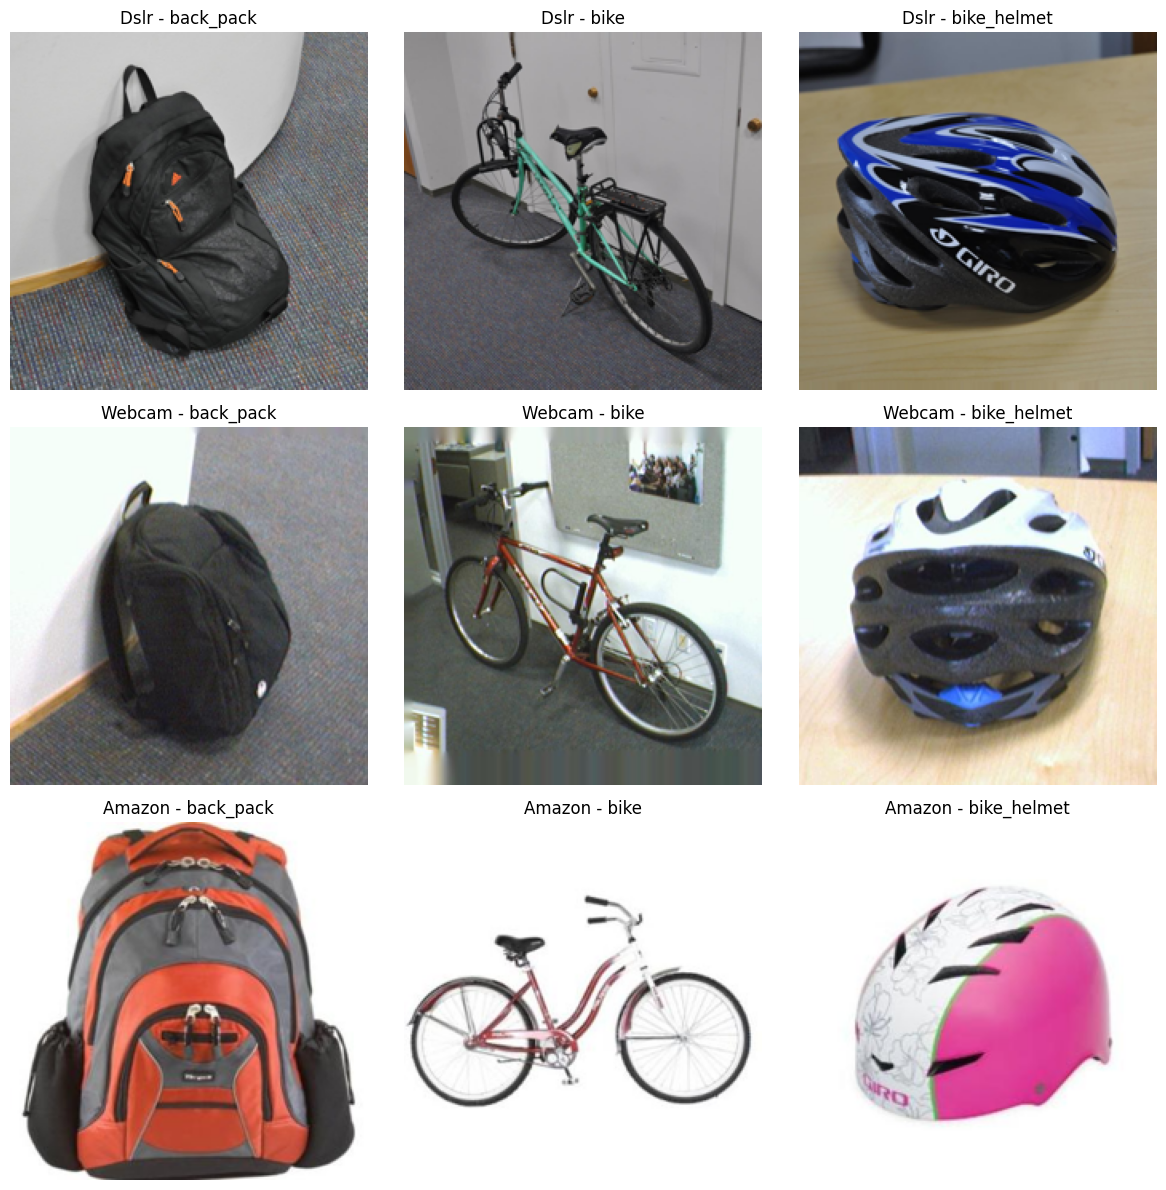

In [18]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Show images per folder from the Office-31 dataset (DSLR, Webcam, Amazon)
def show_sample_images_per_folder(root_dir):
    domains = ['dslr', 'webcam', 'amazon']

    fig, axs = plt.subplots(len(domains), 3, figsize=(12, 4 * len(domains)))

    for row, domain in enumerate(domains):
        domain_folder = os.path.join(root_dir, domain)

        # Get the subfolders (categories) for each domain
        subfolders = sorted(os.listdir(domain_folder))

        for col, subfolder in enumerate(subfolders[1:4]):  # Show 3 random categories for simplicity
            folder_path = os.path.join(domain_folder, subfolder)

            # Get a random image from the category folder
            image_files = os.listdir(folder_path)
            random_image = random.choice(image_files)

            # Open the image using PIL
            img_path = os.path.join(folder_path, random_image)
            img = Image.open(img_path)
            img = img.resize((224, 224))  # Resize to match the model input size

            # Display the image
            axs[row, col].imshow(img)
            axs[row, col].set_title(f"{domain.capitalize()} - {subfolder}")
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()
show_sample_images_per_folder(root_dir)


As seen, the picture vary over each camera: Amazon, DSLR, Webcam, through color contrast, background environment, shadow and/or haze.

# Data Analysis on Distribution Shift

We will extract the Kolmogorov-Smirnov (KS) & Jensen Shannon (JS) Divergence scores between the source and target domains Webcam and DSLR

KS Test answers the question if two dataset distributions (in our case the webcam and DSLR) are drawn from the same data distribution by measuring the maximum vertical distance. If the distance is small, the distributions are similar, else if it is large, the distributions are different. KS plots the Cumulative Distribution Function (CDF) of each dataset and finds the biggest gap between them

JS Divergence, however, focuses on probability distributions, specifically the average of the two distributions and measures how each 

# Statistical Formulas

## Kolmogorov-Smirnov Test (KS Test)

The KS statistic measures the maximum distance between two cumulative distribution functions (CDFs), \( F_n(x) \) and \( G_m(x) \):

$$

D_{n,m} = \sup_x | F_n(x) - G_m(x) |

$$

where:
- $ D_{n,m} $  is the KS statistic,
- $ F_n(x) $ is the empirical CDF of the first sample,
- $ G_m(x) $ is the empirical CDF of the second sample,
- $ \sup_x $ denotes the supremum (maximum) over all $ x $.

---

## Jensen-Shannon Divergence (JSD)

The JSD measures the similarity between two probability distributions \( P \) and \( Q \):

$$

\text{JSD}(P \parallel Q) = \frac{1}{2} D_{\text{KL}}(P \parallel M) + \frac{1}{2} D_{\text{KL}}(Q \parallel M)


$$

where:
- $ M = \frac{1}{2}(P + Q) $ is the average distribution,
- $ D_{\text{KL}}(P \parallel M) $ is the Kullback-Leibler divergence from $ P $ to $ M $,
- $ D_{\text{KL}}(Q \parallel M) $ is the Kullback-Leibler divergence from $ Q $ to $ M $.

The KL Divergence $ D_{\text{KL}} $ is defined as:

$$
D_{\text{KL}}(P \parallel Q) = \sum_i P(i) \log \left( \frac{P(i)}{Q(i)} \right)
$$

In a Domain Adaptation research project, it's crucial to measure how different the source and target data distributions are, since the primary challenge lies in training a model on one domain and ensuring it performs well on another with a potentially different distribution. 

This is where Kolmogorov-Smirnov (KS) and Jensen-Shannon (JS) Divergence become valuable tools. The KS test is useful for statistically testing whether the source and target distributions (e.g., pixel intensities or individual feature values) come from the same population, offering a formal hypothesis test with p-values. 

JS Divergence provides a smooth, symmetric measure to quantify the distance between two probability distributions, making it particularly effective for comparing softmax outputs or high-dimensional learned feature embeddings.

This segment will identify the p-values, KS statistic and JS Divergence score over the covariance matrices of the source and target datasets, which are DSLR and Webcam respectively.

In [ ]:
# Distribution shift testing

def compute_distribution_shift(dataset1, dataset2, name1="Source", name2="Target"):
    sample_loader1 = DataLoader(dataset1, batch_size=64, shuffle=False)
    sample_loader2 = DataLoader(dataset2, batch_size=64, shuffle=False)

    features1 = [] 
    features2 = []

    model = EfficientNet.from_pretrained('efficientnet-b0')
    model._fc = nn.Identity()
    model = model.to(device)
    model.eval()

    with torch.no_grad(): # Disable gradient calculation to save memory and computation
        # Extract features from the model
        for x, _ in sample_loader1:
            x = x.to(device) #Store on device
            f = model(x).cpu().numpy() # Extract features
            features1.append(f)  # Append features1
            if len(features1) > 3: break  # Stop after 3 batches

        for x, _ in sample_loader2:
            x = x.to(device)
            f = model(x).cpu().numpy()
            features2.append(f)  # Append features2
            if len(features2) > 3: break  # Stop after 3 batches

    features1 = np.concatenate(features1, axis=0)
    features2 = np.concatenate(features2, axis=0)

    jsd = jensenshannon(np.abs(np.mean(features1, axis=0)), np.abs(np.mean(features2, axis=0))) # JSD - Pass absolute value features reresenting probability vectors
    ks_stat, ks_p = ks_2samp(np.mean(features1, axis=1), np.mean(features2, axis=1)) # KS test - Compare the mean of the features


    print(f"\nDistribution shift from {name1} to {name2}:")
    print(f"  Jensen-Shannon Divergence: {jsd:.4f}")
    print(f"  Kolmogorov-Smirnov Test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

compute_distribution_shift(dslr_dataset, webcam_dataset, "DSLR", "Webcam")


Loaded pretrained weights for efficientnet-b0

Distribution shift from DSLR to Webcam:
  Jensen-Shannon Divergence: 0.1421
  Kolmogorov-Smirnov Test: statistic=0.0612, p-value=0.8965


Although the numbers at first suggest that the DSLR and Webcam datasets are similar, a closer look shows that there is an important difference between them. The Jensen-Shannon Divergence (JS) is 0.1421, which, although not huge, clearly shows that the average features of the two datasets are not the same. A JS value greater than zero already means the distributions are different. Meanwhile, the Kolmogorov-Smirnov (KS) test gives a small statistic (0.0612) and a high p-value (0.8965), which normally suggests no strong difference between the two datasets. However, the KS test might miss subtle but important differences, especially when comparing complex, high-dimensional features.

The scores show us that the distribution are somewhat identical, however they aren't similar in real world standards

# Model Architecture and Loss Function

## Data Loaders

We initialize separate `DataLoader` objects for the source and target domains. The source domain (DSLR) data is shuffled to improve generalization during training, while the target domain (Webcam) data remains in order for evaluation.

```python
dslr_loader = DataLoader(dslr_dataset, batch_size=BATCH_SIZE, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=BATCH_SIZE, shuffle=False)

The ```CoralLoss``` class implements the CORrelation ALignment (CORAL) loss function, which is used in domain adaptation to minimize the domain shift between source and target feature distributions. It does so by aligning their second-order statistics (i.e., covariance matrices).

CORAL (CORrelation ALignment) Loss is defined as the distance between the covariance matrices of the source and target feature embeddings. These embeddings are extracted from intermediate layers of the network. The objective is to minimize domain shift by reducing the discrepancy between the second-order statistics (i.e., covariances) of the source and target domains. In the context of the altered EfficientNet V2, CORAL loss encourages the network to learn features that are domain-invariant, hence aligning the distributions of the source and target embeddings on a multidimensional plane.

The formula is given for Coral:

$$
\mathcal{L}_{\text{CORAL}} = \frac{1}{4d^2} \left\| C_S - C_T \right\|_F^2
$$

where $ \left\|\right\|_F $ represent the Frobenius norm.

The Frobenius norm, represented by:

$$
\| A \|_F = \sqrt{ \sum_{i=1}^{m} \sum_{j=1}^{n} |a_{ij}|^2 }
$$

Calculates the distance between two covariance embeddings between the matrices

In order to calculate second-order statistics (covariances):

$$
C = \frac{1}{n - 1} X^\top X - \frac{1}{n(n - 1)} X^\top \mathbf{1} \mathbf{1}^\top X
$$

$$
\begin{aligned}
X &\in \mathbb{R}^{n \times d} \quad &\text{Feature matrix (}n\text{ samples, }d\text{ features)} \\
\mathbf{1} &\in \mathbb{R}^{n \times 1} \quad &\text{Vector of all ones} \\
X^\top &\in \mathbb{R}^{d \times n} \quad &\text{Transpose of }X \\
C &\in \mathbb{R}^{d \times d} \quad &\text{Covariance matrix} \\
n &\in \mathbb{N} \quad &\text{Number of samples in the batch}
\end{aligned}
$$

In [18]:

# DataLoaders
dslr_loader = DataLoader(dslr_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle for training
webcam_loader = DataLoader(webcam_dataset, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for testing

# Deep CORAL Loss
class CoralLoss(nn.Module):
    def forward(self, source, target):
        d = source.size(1)

        # Calculate the covariance matrices
        source_c = self.covariance(source)
        target_c = self.covariance(target)


        # Calculate the CORAL loss
        # CORAL loss is the Frobenius norm of the difference between the covariance matrices
        # The covariance matrices are of shape (d, d) where d is the feature dimension


        loss = torch.mean(torch.mul((source_c - target_c), (source_c - target_c)))
        return loss / (4 * d * d)

    def covariance(self, x):
        # Calculate the covariance matrix of x
        # x is of shape (N, D) where N is the batch size and D is the feature dimension
        x = x - x.mean(dim=0, keepdim=True) # Center the data
        return x.T @ x / (x.size(0) - 1) # Covariance matrix

# Feature Extractor + Classifier
class DomainNet(nn.Module):
    def __init__(self, use_coral=False):
        super().__init__()
        self.use_coral = use_coral # Use CORAL loss
        self.feature_extractor = EfficientNet.from_pretrained('efficientnet-b0') # Pretrained EfficientNet
        self.feature_extractor._fc = nn.Identity() # Remove the final classification layer
        self.classifier = nn.Linear(1280, NUM_CLASSES) # Final classification layer

    def forward(self, x):
        features = self.feature_extractor(x) # Extract features
        logits = self.classifier(features) # Classify
        return logits, features # Extract features for CORAL loss



# Training CORAL / No CORAL

This function handles the model training process, with an option to include the Deep CORAL loss for domain adaptation. It returns the trained model and a list of loss values per epoch.

The function initializes a DomainNet model with or without CORAL.

During each epoch, it trains on both the source domain (e.g., DSLR) and target domain (e.g., Webcam):

If CORAL is enabled:

Uses both classification loss on source labels and CORAL loss to align source/target features.

Otherwise:

Only classification loss is used on the source data.

After each epoch, the current loss is printed and stored


In [19]:

# Training Loop

def train_model(use_coral=False):
    loss_list=[] # Store Loss List
    model = DomainNet(use_coral=use_coral).to(device) # Initialize model
    optimizer = optim.Adam(model.parameters()) # Optimizer

    if use_coral:
        class_criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification
        coral_criterion = CoralLoss() # CORAL loss for domain adaptation
    else:
        criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification

    model.train()
    for epoch in range(EPOCHS): # Training loop
        for (src_x, src_y), (tgt_x, _) in zip(dslr_loader, webcam_loader): # Source and Target data
            src_x, src_y = src_x.to(device), src_y.to(device) # Source data convert to store on device
            tgt_x = tgt_x.to(device) # Target data convert to store on device

            optimizer.zero_grad() # Zero gradient start
            src_logits, src_feat = model(src_x) # Forward pass

            if use_coral: # If using CORAL loss
                _, tgt_feat = model(tgt_x) # Forward pass for target data
                loss_class = class_criterion(src_logits, src_y) # Cross Entropy Classification Loss
                loss_coral = coral_criterion(src_feat, tgt_feat) # CORAL Loss
                loss = loss_class + loss_coral # Total Loss to be back propagated
            else:
                loss = criterion(src_logits, src_y) # Cross Entropy Classification Loss

            loss.backward() # Backpropagation
            optimizer.step() # Update weights
        print(f"Epoch {epoch+1} | Loss {loss}") # Print loss
        loss_list.append(loss) # Store loss list
    return model, loss_list


# Evaluation Metrics

This function evaluates the performance of a trained model on a target domain dataset (e.g., Webcam). It computes various metrics like accuracy, precision, recall, and F1-score. Additionally, it extracts the features, which are the covariance matrices, used for CORAL Loss, from the model's penultimate layer.

In [20]:

# Evaluation
def evaluate(model):
    model.eval() # Start Evaluation mode
    y_true, y_pred, feats = [], [], [] # Store true and predicted labels and features

    with torch.no_grad(): #Evaluation loop - disable gradient calculation to save memory
        for x, y in webcam_loader: # Load target data
            x = x.to(device) # Convert to device
            logits, features = model(x) # Forward pass -> get logits and features
            preds = torch.argmax(logits, dim=1).cpu().numpy() # Get predicted labels
            y_pred.extend(preds) # Store predicted labels
            y_true.extend(y.numpy()) # Store true labels
            feats.append(features.cpu().numpy()) # Store features

    feats = np.concatenate(feats, axis=0) # Concatenate features
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro'),
        "recall": recall_score(y_true, y_pred, average='macro'),
        "f1": f1_score(y_true, y_pred, average='macro'),
        "features": feats
    }


# Trial Execution for Model Evaluation

In this section, we define the trial execution process for evaluating the performance of models with and without Deep CORAL. This approach runs multiple trials and computes the average performance metrics, such as accuracy, precision, recall, and F1-score. The results are used to compare the effectiveness of the models with and without the CORAL loss.

There will be 3 trials, and the evaluations will be averaged 

In [21]:
total_loss_list=[]

# Trial Execution
def run_trials(use_coral=False):
    metrics_all = [] # Store metrics
    total_time = 0 # Store time
    TRIALS=3
    for trial in range(TRIALS): # Loop for trials
        print(f"Trial {trial+1}/{TRIALS} {'[With CORAL]' if use_coral else '[Baseline]'}")
        model, loss_list=train_model(use_coral=use_coral) # Train model, return the trained model and loss list
        eval_metrics = evaluate(model) # Evaluate model
        metrics_all.append(eval_metrics) # Store metrics
        total_loss_list.append(loss_list) # Store loss list

    avg = {
        key: np.mean([m[key] for m in metrics_all]) for key in ['accuracy', 'precision', 'recall', 'f1'] # Average metrics among all 3 trials
    }
    return avg, model, metrics_all[-1]["features"]

# Run Experiments
print("Running Control (No CORAL)...")
ctrl_results, ctrl_model, ctrl_feats = run_trials(use_coral=False) # Baseline

print("\nRunning Deep CORAL...")
coral_results, coral_model, coral_feats = run_trials(use_coral=True) # Deep CORAL


Running Control (No CORAL)...
Trial 1/3 [Baseline]
Loaded pretrained weights for efficientnet-b0
Epoch 1 | Loss 1.6260254383087158
Epoch 2 | Loss 0.9737294912338257
Epoch 3 | Loss 0.8986795544624329
Epoch 4 | Loss 0.11155245453119278
Epoch 5 | Loss 0.36964911222457886
Epoch 6 | Loss 0.9765341877937317
Epoch 7 | Loss 0.43934717774391174
Epoch 8 | Loss 0.30194684863090515
Epoch 9 | Loss 0.17917656898498535
Epoch 10 | Loss 0.19187739491462708
Trial 2/3 [Baseline]
Loaded pretrained weights for efficientnet-b0
Epoch 1 | Loss 1.8398244380950928
Epoch 2 | Loss 1.3623546361923218
Epoch 3 | Loss 0.654396653175354
Epoch 4 | Loss 0.3053005337715149
Epoch 5 | Loss 0.5666362047195435
Epoch 6 | Loss 0.06287890672683716
Epoch 7 | Loss 0.08228791505098343
Epoch 8 | Loss 0.05930238217115402
Epoch 9 | Loss 0.15529030561447144
Epoch 10 | Loss 0.2961316704750061
Trial 3/3 [Baseline]
Loaded pretrained weights for efficientnet-b0
Epoch 1 | Loss 1.8813457489013672
Epoch 2 | Loss 1.1537307500839233
Epoch 3 | 

In [22]:


# Results
print("\n=== Final Averaged Results ===")
print("Baseline (No CORAL):", ctrl_results)
print("With Deep CORAL:", coral_results)


=== Final Averaged Results ===
Baseline (No CORAL): {'accuracy': np.float64(0.9431524547803618), 'precision': np.float64(0.9424032489249882), 'recall': np.float64(0.9317822333611807), 'f1': np.float64(0.9269902776035442)}
With Deep CORAL: {'accuracy': np.float64(0.9793281653746769), 'precision': np.float64(0.9779696969696969), 'recall': np.float64(0.9764883984153934), 'f1': np.float64(0.975497023373915)}


In [23]:
def plot_tensor(tensor_list):
  raw_values = np.array([t.item() for t in tensor_list]) # Convert to numpy array
  return raw_values

In [24]:
#No CORAL Loss graph Trial 1,2,3

trial_1 = total_loss_list[0] # Loss for trial 1
trial_2 = total_loss_list[1] # Loss for trial 2
trial_3 = total_loss_list[2] # Loss for trial 3

#CORAL Loss graph Trial 1,2,3

c_trial_1 = total_loss_list[3] # Loss for trial 1
c_trial_2 = total_loss_list[4] # Loss for trial 2
c_trial_3 = total_loss_list[5] # Loss for trial 3

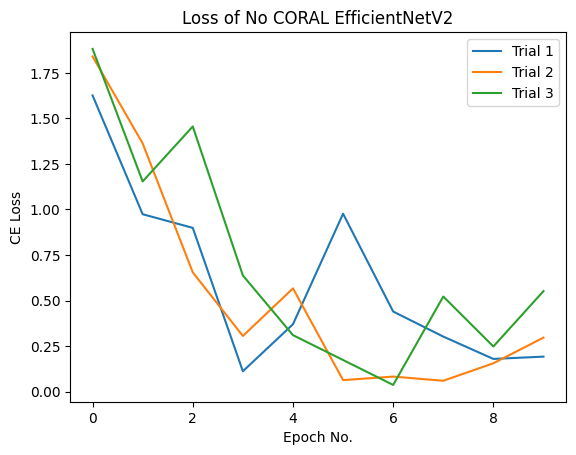

In [31]:
plt.plot(plot_tensor(trial_1), label="Trial 1") # Plot loss for trial 1
plt.plot(plot_tensor(trial_2), label="Trial 2") # Plot loss for trial 2
plt.plot(plot_tensor(trial_3), label="Trial 3") # Plot loss for trial 3

plt.legend()

plt.ylabel("CE Loss")
plt.xlabel("Epoch No.")
plt.title("Loss of No CORAL EfficientNetV2")

plt.savefig("Result/Loss-of-No-CORAL-EfficientNetV2.png")

plt.show()

Without the use of CORAL, the loss of the model exhibits significant fluctuations

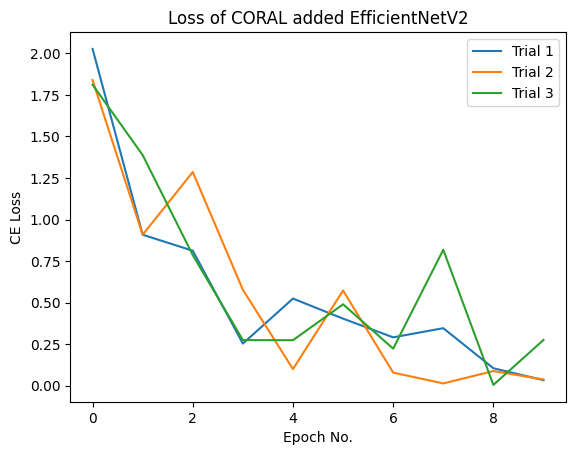

In [30]:
plt.plot(plot_tensor(c_trial_1), label="Trial 1")
plt.plot(plot_tensor(c_trial_2), label="Trial 2")
plt.plot(plot_tensor(c_trial_3), label="Trial 3")

plt.legend()

plt.ylabel("CE Loss")
plt.xlabel("Epoch No.")

plt.title("Loss of CORAL added EfficientNetV2")

plt.savefig("Result/Loss-of-CORAL-added-EfficientNetV2.png")

plt.show()

With the use of CORAL, the loss of the model exhibits significantly less fluctuations than the control model, showing Domain Adaptation's quality capabilities in smoother-than-normal training.

It is also seen that the CORAL Model has also achieved a lower average loss than the No-CORAL Model.

# Download Data & Model

In [27]:
import pandas as pd

# Create DataFrame with metrics
metrics_df = pd.DataFrame([
    {"Model": "Baseline", **ctrl_results},
    {"Model": "Deep CORAL", **coral_results}
])

print("\n=== Metrics DataFrame ===")
print(metrics_df)

metrics_df.to_csv("Result/Evaluation Base CORAL.csv")



=== Metrics DataFrame ===
        Model  accuracy  precision    recall        f1
0    Baseline  0.943152   0.942403  0.931782  0.926990
1  Deep CORAL  0.979328   0.977970  0.976488  0.975497


In [28]:
torch.save(ctrl_model,"Models/Control-EfficientNet-Model.pt") # Save the model

In [29]:
torch.save(coral_model, "Models/EfficientNet-Model-with-CORAL.pt") # Save the model